# Notebook to make `gif` version of Figure 2

In [ ]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_SNRs/'

### Setup

Load data

In [1]:
# Load in posteriors
posteriors_dict = h5ify.load(data_dir+'posteriors_different_SNRs.h5'),

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in the signals' parameters
injected_params_dict = h5ify.load(data_dir+'parameters_different_SNRs.h5')

# Load in the signals' strain
injection_strain_dict = h5ify.load(data_dir+'waveforms_different_SNRs.h5')

Set up plotting aesthetics

In [2]:
# which SNRs to plot 
SNRs_to_plot = list(posteriors_dict[0].keys())

# colors associated with each SNR
colors = [cp[-1], cp[2], 'yellowgreen', cp[8], cp[1], cp2[1], cp2[3], cp[3], 'maroon']

# mass of the injections
M_inj = injected_params_dict['SNR 15']['mtotal']

In [3]:
# get times and units 
importlib.reload(pf)
cutoff_cycles = list(posteriors_dict[0]['SNR 15'].keys())
cuts_float, unit = pf.get_unique_times(cutoff_cycles)

### Make animation

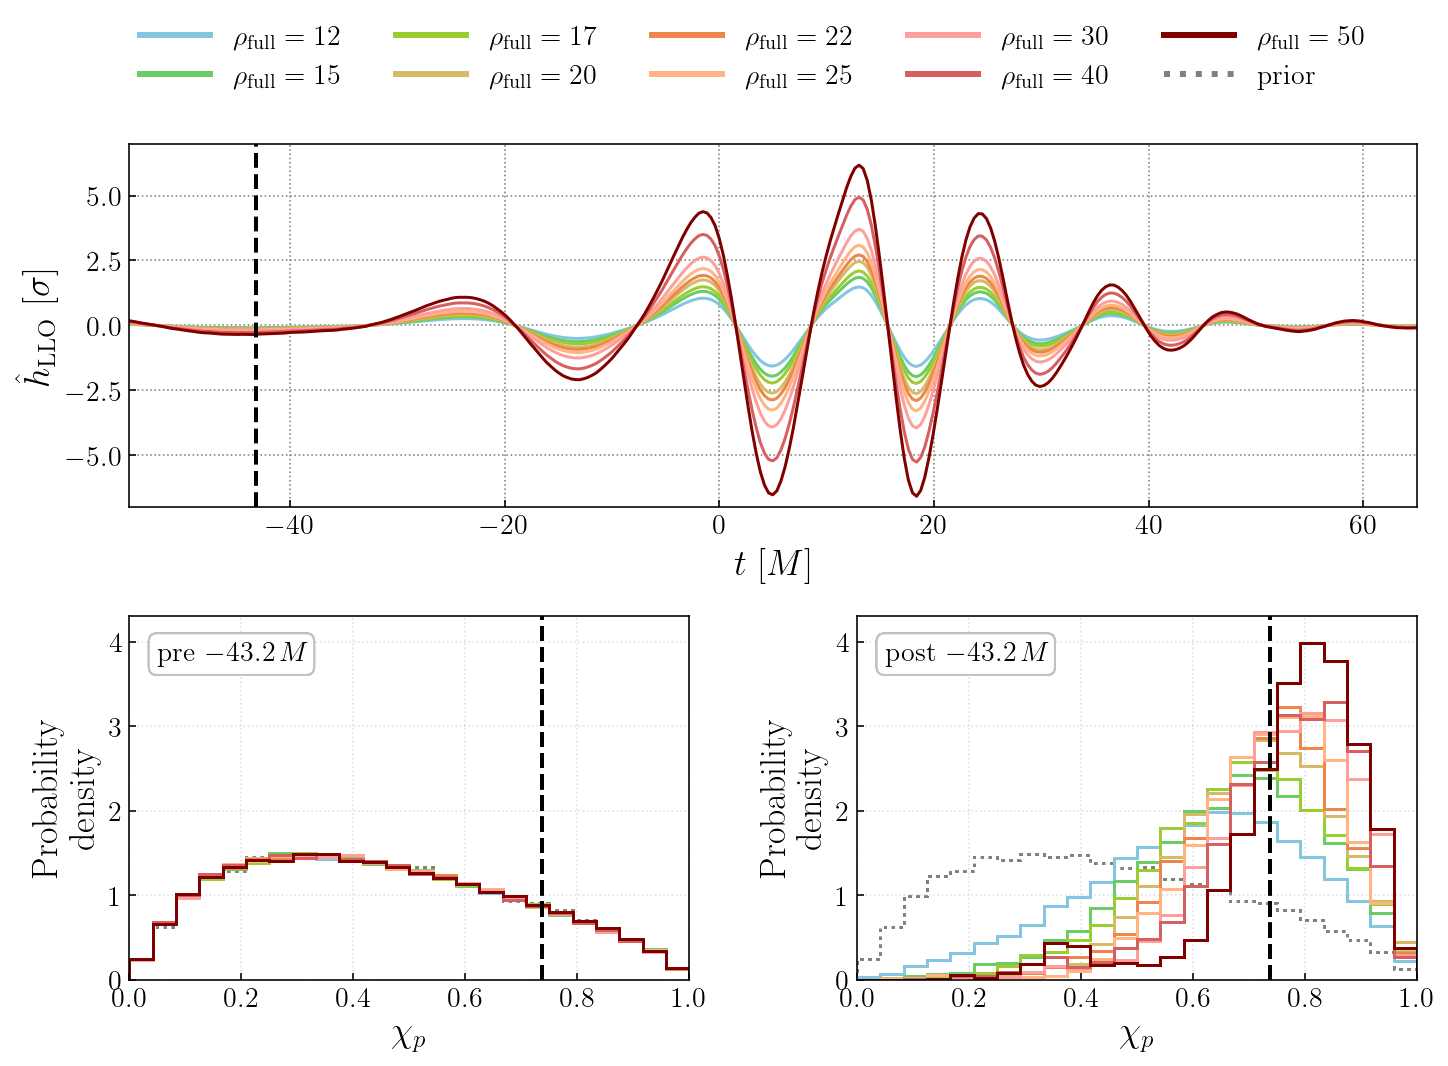

In [4]:
frames = []

for n, cycle in enumerate(cuts_float[2:]): 

    # make figure
    fig = plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH, pf.DEFAULT_FIG_WIDTH/1.5))
    axes1, axes2 = pf.custom_axes(2, [1, 2])

    handles = []
    
    # cycle through cutoff times and SNRs
    for SNR, color in zip(SNRs_to_plot, colors): 
                        
        # plot injections
        ax = axes1[0]
        
        injection = injection_strain_dict[SNR]
        
        ifo = 'L1'
        ref_time_ifo = injected_params_dict[SNR][f'{ifo}_time']
        times = injection['time_dict'][ifo] - ref_time_ifo
        times_M = pf.transform_s_to_M(times, M_inj)
        strain_wh = injection['strain_wh'][ifo]
        
        # get time from cycle
        t = round(pf.get_tcut_from_Ncycles(injection['strain'][ifo], times, float(cycle)), 3)
        
        ax.plot(times_M, strain_wh, c=color)
        pf.set_limits_and_labels_of_whitened_wf_plot(ax, unit='M')        
        ax.set_ylim(-7,7)
        
        # plot chi-p posteriors        
        for i, prepost in enumerate(['pre', 'post']): 
            
            ax = axes2[i]
    
            posterior = posteriors_dict[0][SNR][f'{prepost} {cycle}cycles']
        
            p = 'chi_p'
            bins = np.linspace(pf.xlims[p][0],  pf.xlims[p][-1], 25)
            hist_kws = dict(histtype='step', density=True, bins=bins, lw=1.5, color=color)
            prior_hist_kws = dict(histtype='step', density=True, bins=bins, lw=1.5, 
                                  color='gray', ls=':', zorder=0)

            ymax = 4.3
            pf.plot_posterior(ax, posterior[p], pf.xlims[p], ymax, pf.params[p], ylabel='Probability\ndensity', **hist_kws)
            pf.plot_posterior(ax, prior_dict[p], pf.xlims[p], ymax, pf.params[p], ylabel='Probability\ndensity', **prior_hist_kws)

            true_value = injected_params_dict[SNR][p]
            ax.axvline(true_value, color='k', lw=2, ls='--')
            
                    
            t_M = np.round(pf.transform_s_to_M(t, M_inj),1)
            ax.text(0.05, 0.93, fr'{prepost} ${t_M}\,M$', ha='left', va='top', 
                transform=ax.transAxes, fontsize=14, zorder=5, 
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='silver', boxstyle='round'))

        # concatenate for legend
        handles.append(Line2D([], [], color=color, label = fr'$\rho_{{\rm full}} = {SNR[-2:]}$'))
        
    # shade out the excluded data
    ax = axes1[0]
    ax.axvline(float(t_M), color='k', ls='--', lw=2)

    # add legend
    handles.append(Line2D([], [], color='gray', ls=':', label = 'prior')) 
    pf.add_legend(fig, handle_lw=3, handles=handles, ncol=int(len(handles)/2), loc='upper center', 
                  bbox_to_anchor=(0.5, 1.01), handlelength=2.5)
    
    # adjust spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # savename
    savename = f'for_gif_figure_02/frame{n:02}.png'
    plt.savefig(savename, dpi=300, bbox_inches='tight')
    
    if n==0: 
        plt.show()
    else: 
        plt.close()
    
    # append to `frames` which will be used to make the gif
    image = imageio.v2.imread(savename)
    frames.append(image)

In [5]:
# Assemble into a gif
fps = 1.5
imageio.mimsave('gif_figure_02.gif', frames, fps=fps) 